#  Proximal Policy Optimization


This notebook implements Proximal Policy Optimization and describes each detail in step. Please refer to the readme to gain a deeper understanding of the conceptual peices of the paper. 

The environment to solve is Unity's [Tennis Environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md). Please refer to the readme or the link for more information. In general, to achieve an average score of 0.5 is considered "solving" the environment.

### Import Necessary Packages

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import os
import pdb
import numpy as np
import torch.optim as optim
from unityagents import UnityEnvironment
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### The Policy

PPO implements an actor-critic architecture to estimate the action policy and state-value function. Please refer to the readme for more details.

The following cells were modified/inspired from:
[Olivier St-Amand](https://github.com/ostamand), [Lilian Weng](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#maddpg), [Thomas Simonini](https://towardsdatascience.com/proximal-policy-optimization-ppo-with-sonic-the-hedgehog-2-and-3-c9c21dbed5e), [Shangtong Zhang](https://github.com/ShangtongZhang/DeepRL).

In [2]:
class ActorCritic(nn.Module):

    def __init__(self, state_size, action_size, hidden_size=[512, 256]):
        
        """ 
        
        initialize the ActorCritic class
        
        params:
            state_size   -  size of the observation space vector
            action_size  -  size of the action space vector
            hidden_size  -  list containing the input/output dimensions of
                            the hidden layer.
        """
        
        super(ActorCritic, self).__init__()
        
        # two neural network layers. These layer will 
        # be used by both the actor and critic initially.
        self.fc1 = nn.Linear(state_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        
        # Actor. output the continuous values for the action vector.
        self.actor = nn.Linear(hidden_size[1], action_size)
        
        # Interestly, Olivier St-Amand uses a neural network to estimate the standard
        # deviation of the action policy distribution. 
        # In most other implementations, this value is usually fixed to 1.
        self.actor_std = nn.Linear(hidden_size[1], action_size)

        # Critic. map state to a single value. 
        self.critic = nn.Linear(hidden_size[1], 1)

    def forward(self, x, actions=None):
        """
        
        forward pass through actor-critic network.
        
        Params:
            x      - observation vector
            action - vector of actions. used when calculating r(theta). 
                     See readme for detailed explanation of r(theta) and
                     how it is used.
        
        """
        
        # move input 'x' through layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Actor. obtain the estimated action vector values.
        # tanh returns values between -1 and 1, which is also 
        # the range of the Unity environment.
        estimated_actions = torch.tanh(self.actor(x))
        
        # Olivier St-Amand uses a SOFTPLUS here. The softplus function outputs values 
        # within [0, +infinity]. Appropriate for a standard deviation.
        action_distribution_std = F.softplus(self.actor_std(x))
        
        # using 'actions' as a mean and the deviations obtained above, create a Gaussian distribution
        action_distribution = torch.distributions.Normal(estimated_actions, action_distribution_std)
        
        # if no actions where passed in, sample from this distribution to obtain
        # a vector of action values.
        if actions is None:
            actions = action_distribution.sample()
        
        # obtain the log probability of the action policy. 
        # this is equation (2) from the paper.
        log_probabilities = action_distribution.log_prob(actions)

        # Critic.
        # estimate the state value, V(s) -> v.
        state_value_estimate = self.critic(x)

        # the entropy of a distribution can be obtained directly through the entropy() 
        # method. This is useful for equation (9) from the paper, when including an
        # "entropy bonus".
        return actions, log_probabilities, action_distribution.entropy(), state_value_estimate


### PPO Agent

The PPO Agent will use the actor-critic policy defined above to train itself in this Unity Environment. The PPO algorithm is implemented in the step() function. For a more detailed explanation, please view the readme.

In [3]:

class PPOAgent():
    
    def __init__(self, env=None, 
                 bootstrap_length=2048,   epochs=10,   batch_size=32,   epsilon=0.1, 
                 lrate=1e-4,   lrate_schedule=lambda it: max(0.995 ** it, 0.01), 
                 entropy_coeff=0.00,   vf_coeff=1.0,   gae_tau=0.95, 
                 discount_factor=0.99,   gradient_clip=0.5):
        
        """
        
        Initialize PPO Agent
        
        params:
        
            env                - unity environment
            bootstrap_length   - number of iterations to populate trajectory
            epochs             - number of iterations to perform SGD on policy
            batch_size         - number of experiences to sample from trajectory
            epsilon            - clip probability ratio by this amount
            lrate              - learning rate for policy optimizer
            lrate_schedule     - REMOVE
            entropy_coeff      - degree to which the entropy bonus is incorporated into 
                                 surrogate. see equation (9)
            vf_coeff           - degree to which the value function is incorporated into
                                 surrogate. see equation (9)
            gae_tau            - generalized advantage estimation parameter
            discount_factor    - discount factor for future rewards
            gradient_clip      - clipping parameter for policy gradient
            
        
        
        """
        
        # ensure environment is present.
        assert(env != None)
        
        # set information pertaining to unity environment.
        self.env = env
        self.brain_name = env.brain_names[0]
        self.brain = env.brains[self.brain_name]
        self.env_info = self.env.reset(train_mode=True)[self.brain_name]
        self.num_agents = len(self.env_info.agents)
        self.action_size = self.brain.vector_action_space_size
        self.state = self.env_info.vector_observations
        self.state_size = self.state.shape[1]
        
        # if gpu is available, take advantage.
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        # define the policy to optimize.
        self.policy = ActorCritic(self.state_size, self.action_size).to(self.device)
        
        # hyperparameters
        self.bootstrap_length = bootstrap_length
        self.discount_factor = discount_factor
        self.optimization_epochs = epochs
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.lrate = lrate
        self.gradient_clip = gradient_clip
        self.entropy_coeff = entropy_coeff
        self.vf_coeff = vf_coeff
        self.gae_tau = gae_tau
        self.lrate_schedule = lrate_schedule
        
        # if gpu available, utilize
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        # optimizer
        self.opt = optim.Adam(self.policy.parameters(), lr=self.lrate)

        # lrate scheduler
        self.scheduler = optim.lr_scheduler.LambdaLR(self.opt, lr_lambda=lrate_schedule)

        self.rewards = np.zeros(self.num_agents)
        self.episodes_reward = []
        
        # keep track of total steps taken in environment
        self.steps = 0

    
    @property
    def running_lrate(self):
        return self.opt.param_groups[0]['lr']
    
    
    def close_env(self):
        """ 
        
        terminate the unity environment
        
        """
        self.env.close()
        
    def reset(self, is_training=True):
        """ 
        
        reset unity environment and return observation vector
        
        params:
            is_training - boolean. place unity environment in training mode or not.
        
        """
        
        self.env_info = self.env.reset(train_mode=is_training)[self.brain_name]
        self.state = self.env_info.vector_observations
        return self.state
        
    
    def tensor_from_np(self, x):
        """
        convert numpy array into pytorch tensor
        
        params:
            x - numpy array
        """
        return torch.from_numpy(x).float().to(self.device)

    
    
    def get_batch(self, states, actions, old_log_probs, returns, advs):
        """
         yeild batches of experiences, chosen at random
         
         params:
             states          -  array of observation space vectors
             actions         -  array of action space vectors
             old_log_probs   -  log probabilities of action distributions
             returns         -  returns calculated from a trajectory
             advs            -  advantages calculated from a trajectory
        """
        
        length = states.shape[0]
        
        batch_size = int(length / self.batch_size)
        
        idx = np.random.permutation(length)
        
        for i in range(self.batch_size):
            
            rge = idx[i*batch_size:(i+1)*batch_size]
            
            yield (states[rge], actions[rge], old_log_probs[rge], returns[rge], advs[rge].squeeze(1))
            

    def step(self):
        
        # step lrate scheduler
        self.scheduler.step()

        # begin bootstrapping
        
        # holds all experience tuples from this bootstrap session.
        trajectory_raw = []
        
        for _ in range(self.bootstrap_length):

            # convert current state to tensor
            state = self.tensor_from_np(self.state)
            
            # pass current state through policy to obtain estimated actions, log probabilities of these actions,
            # and the critics estimation of the value of this state.
            action, log_p, _, value = self.policy(state)

            # detach variables
            log_p = log_p.detach().cpu().numpy()
            value = value.detach().squeeze(1).cpu().numpy()
            action = action.detach().cpu().numpy()

            # using the estimated actions, advance the environment
            self.env_info = self.env.step(np.clip(action, -1, 1))[self.brain_name]
            next_state = self.env_info.vector_observations
            reward = np.array(self.env_info.rewards)
            done = np.array(self.env_info.local_done)
                        
            # collect reward. this is a running total
            self.rewards += reward

            # check if some episodes are done
            for i, d in enumerate(done):
                
                if d:
                    # for this episode that has completed, set its final reward.  
                    self.episodes_reward.append(self.rewards[i])
                    
                    # since we are no longer collecting rewards for this episode (have places into
                    # 'episodes_reward'), set to 0.
                    self.rewards[i] = 0

            # add this trajectory to the list
            trajectory_raw.append((state, action, reward, log_p, value, 1-done))
            
            
            if np.any(done):
                # reset state
                self.state = self.reset()
            else:
                # advance state
                self.state = next_state
            
            
        # finished bootstrapping 
        # time to calculate advantages and returns of the trajectory. 
        # see the Algorithm 1 in paper. This portion is equivalent to
        # "Compute advantage estimates..."
        
        # get the estimated value of the terminating state from critic
        next_value = self.policy(self.tensor_from_np(self.state))[-1].detach().squeeze(1)
        
        # create final trajectory
        trajectory_raw.append((state, None, None, None, next_value.cpu().numpy(), None))
        trajectory = [None] * (len(trajectory_raw)-1)
        
        # process raw trajectories
        # calculate advantages and returns
        advs = torch.zeros(self.num_agents, 1).to(self.device)
        
        R = next_value

        # from last to first
        for i in reversed(range(len(trajectory_raw)-1)):

            # grab trajectory_i
            states, actions, rewards, log_probs, values, dones = trajectory_raw[i]
            
            # convert each of these into a tensor.
            # the new variable is 'next_values', which is the successive trajectory values.
            actions, rewards, dones, values, next_values, log_probs = map(
                lambda x: torch.tensor(x).float().to(self.device),
            (actions, rewards, dones, values, trajectory_raw[i+1][-2], log_probs))
            
            # calculate the return.
            # if an epsiode terminated, dones[terminating-episode-index] == 0, so that reward is the return.
            R = rewards + self.discount_factor * R * dones
            
            # at this point, Generalized ADVANTAGE Estimation (GAE) is implemented.
            # GAE can be used with virtually any policy-based method, such as PPO here.
            # https://arxiv.org/abs/1506.02438
            
            # without GAE, advantage is calculated as: adv = Returns - Values; see the 
            # readme for a detailed explanation.
            td_errors = rewards + self.discount_factor * dones * next_values - values
            advs = advs * self.gae_tau * self.discount_factor * dones[:, None] + td_errors[:, None]
            
            # insert the advantage into the list. These will be used to train the network.
            trajectory[i] = (states, actions, log_probs, R, advs)

        # for every (states, actions, log_probs, R, advs), map to corresponding variables. 
        states, actions, old_log_probs, returns, advs = map(lambda x: torch.cat(x, dim=0), zip(*trajectory))

        # normalize advantages
        advs = (advs - advs.mean())  / (advs.std())

        
        # train policy with random batchs of accumulated trajectories
        for _ in range(self.optimization_epochs):

            for states_b, actions_b, old_log_probs_b, returns_b, advs_b in \
                self.get_batch(states, actions, old_log_probs, returns, advs):

                # get updated values from policy. Note at this point that actions are passed in, acting
                # as the mean to a distribution and the resulting new log_probabilities are obtained. 
                _, new_log_probs_b, entropy_b, values_b = self.policy(states_b, actions_b)

                # obtain the ratio. expo() will returns a new tensor 
                # with the exponential of the difference of the new and old log probabilties.
                # this is r(theta) is equation (6) of the paper.
                ratio = (new_log_probs_b - old_log_probs_b).exp()

                # Clipped function, equation (7)
                clip = torch.clamp(ratio, 1-self.epsilon, 1+self.epsilon)                
                # implement equation (7) of the paper.
                clipped_surrogate = torch.min(ratio*advs_b.unsqueeze(1), clip*advs_b.unsqueeze(1))

                # actor loss.
                actor_loss = -torch.mean(clipped_surrogate) - self.entropy_coeff * entropy_b.mean()
                
                # critic loss, according to equation (9) in the paper. 
                # in the paper, the critic loss hyper-parameter is 1.
                critic_loss = F.smooth_l1_loss(values_b, returns_b.unsqueeze(1))

                # remove any preexisting gradient
                self.opt.zero_grad()
                
                # backprop surrogate
                (actor_loss + critic_loss).backward()
                
                # clip the gradient values. stabilitizes learning
                nn.utils.clip_grad_norm_(self.policy.parameters(), self.gradient_clip)
                
                # optimize policy
                self.opt.step()

        # steps of the environement processed by the agent 
        self.steps += self.bootstrap_length * self.num_agents


In [4]:

def train(agent, iterations=500,  print_every=1,  policy_save_threshold=0.5):
    """
    
    train a PPO agent and visualize running rewards
    
    params:
        iterations             -  amount to run the agent.step() method
        print_every            -  the rate at which to log rewards
        policy_save_threshold  - the reward value at which 
                                 to start saving the policy parameters
    
    """
    
    # will hold all rewards
    rewards = []
    
    # will hold the mean rewards from each iteration
    mean_per_iteration = []
    
    for iter in range(iterations):
        
        # step agent. 
        agent.step()

        # grab last 100 rewards from agent
        if len(agent.episodes_reward) >= 100:
            
            # last 100 rewards
            r = agent.episodes_reward[:-101:-1]
            # append stats
            rewards.append((agent.steps, min(r), max(r), np.mean(r), np.std(r)))

        # check logging condition
        if (iter+1) % print_every == 0:
            
            # variable to print
            summary = ''
            
            if rewards:
                
                mean = rewards[-1][3]
                minimum = rewards[-1][1]
                maximum = rewards[-1][2]
                summary = f'Rewards: {mean:.2f}/{rewards[-1][4]:.2f}/{minimum:.2f}/{maximum:.2f} (mean/std/min/max)'
                mean_per_iteration.append(mean)

                if mean >= policy_save_threshold:
                    policy_save_threshold = mean
                    torch.save(agent.policy.state_dict(), '.\ppo_tennis_best.pth')
                    print('\ntarget reward obtained!')
                    break
                    
            # clear prior output, print stats and plot learning curve.
            clear_output(True)
            print(f"Iteration: {iter+1:d}\nEpisodes: {len(agent.episodes_reward)}\nSteps: {agent.steps:d}\nlrate: {agent.running_lrate:.2E}\n{summary}", end="")
            plt.figure(figsize=(40,5))
            plt.subplot(131)
            plt.xlabel('iteration')
            plt.ylabel('mean reward')
            plt.plot(mean_per_iteration)
            plt.show()


### Train the Agent

Instantiate the environment and train the agent. 

Iteration: 88
Episodes: 10932
Steps: 360448
lrate: 6.47E-05
Rewards: 0.46/0.55/-0.01/2.60 (mean/std/min/max)

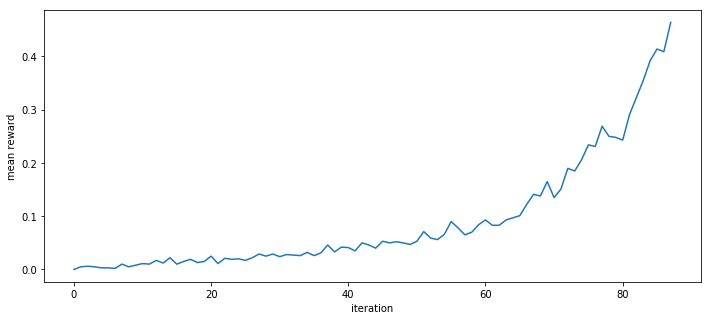


target reward obtained!


In [5]:
# instantiate unity environment
env = UnityEnvironment(file_name='Tennis.exe', no_graphics=False)  

# instantiate agent
agent = PPOAgent(env)

# train the agent
train(agent)

### Watch the Agents Play Tennis!

Test the agent using the best performing policy parameters.

In [6]:
# load best performing policy
agent.policy.load_state_dict(torch.load('ppo_tennis_best.pth'))

# reset state and set training mode to false
state = agent.reset(is_training=False)

scores = np.zeros(agent.num_agents)

for i in range(500):
    
    state = agent.tensor_from_np(np.array(state))
    action, _, _, _ = agent.policy(state)
    action = action.detach().cpu().numpy()
    action = np.clip(action, -1, 1)                                  # all actions between -1 and 1
    env_info = agent.env.step(action)[agent.brain_name]    # send all actions to tne environment
    next_states = env_info.vector_observations                       # get next state (for each agent)
    rewards = env_info.rewards                                       # get reward (for each agent)
    dones = env_info.local_done                                      # see if episode finished
    scores += env_info.rewards                                       # update the score (for each agent)
    state = next_states                                              # roll over states to next time step        
    if np.any(dones):                                                 # reset if episode finished
        # reset state
        state = agent.reset()
    else:
        # advance state
        state = next_states
        
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))


Total score (averaged over agents) this episode: 1.2450000187382102


In [7]:
# close the unity environment
agent.close_env()